# Import des bibliothèques


In [31]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_curve, auc ,f1_score
)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import chromadb

# Import des donnes depuis chromaDB


In [3]:

client = chromadb.PersistentClient(path="/opt/airflow/data/chroma_db")

train_collection = client.get_or_create_collection("avis_train")
test_collection  = client.get_or_create_collection("avis_test")

train_results = train_collection.get(
    include=["metadatas", "embeddings", "documents"]
)

x_train = np.array(train_results["embeddings"])
y_train = [m["label"] for m in train_results["metadatas"]]
train_texts = train_results["documents"]

test_results = test_collection.get(
    include=["metadatas", "embeddings", "documents"]
)

x_test = np.array(test_results["embeddings"])
y_test = [m["label"] for m in test_results["metadatas"]]
test_texts = test_results["documents"]



# Import de LabelEncoder pour encoder Label


In [18]:

le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

classes = sorted(list(set(y_train)))
y_test_bin = label_binarize(y_test, classes=classes)
y_train_bin = label_binarize(y_train, classes=classes)

# Entraînement — Logistic Regression
.

=== Logistic Regression ===
=== Logistic Regression (après GridSearch) ===
Accuracy train: 0.8343
Accuracy test : 0.8019
Gap (overfitting): 0.0324
=== Logistic Regression (après GridSearch) ===
Accuracy train: 0.7795
Accuracy test : 0.7347
Gap (overfitting): 0.0447


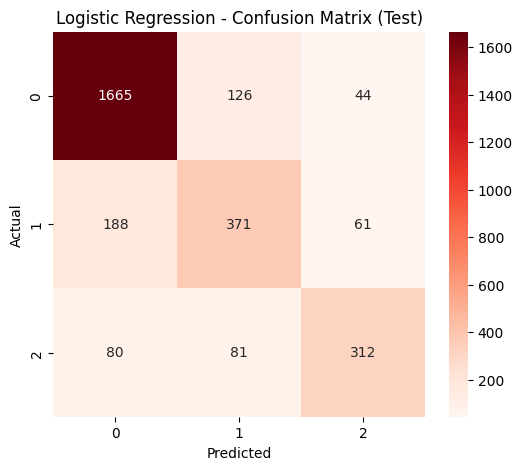

,precision,recall,f1-score,support
negative,0.861355,0.907357,0.883758,1835.000000
neutral,0.641869,0.598387,0.619366,620.000000
positive,0.748201,0.659619,0.701124,473.000000
accuracy,0.801913,0.801913,0.801913,0.801913
macro avg,0.750475,0.721788,0.734749,2928.000000
weighted avg,0.796600,0.801913,0.798270,2928.000000


In [32]:

LogisticRegression_model=LogisticRegression()


LogisticRegression_model.fit(x_train, y_train)
y_pred_train = LogisticRegression_model.predict(x_train)
y_pred_test  = LogisticRegression_model.predict(x_test)
print("="*50)
print(f"=== Logistic Regression ===")
acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train,average="macro")
f1_test  = f1_score(y_test, y_pred_test,average="macro")



print("="*50)
print("=== Logistic Regression (après GridSearch) ===")
print("="*50)
print(f"Accuracy train: {acc_train:.4f}")
print(f"Accuracy test : {acc_test:.4f}")
print(f"Gap (overfitting): {acc_train - acc_test:.4f}")
print("="*50)



print("="*50)
print("=== Logistic Regression (après GridSearch) ===")
print("="*50)
print(f"Accuracy train: {f1_train:.4f}")
print(f"Accuracy test : {f1_test:.4f}")
print(f"Gap (overfitting): {f1_train - f1_test:.4f}")
print("="*50)
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Reds")
plt.title(f"Logistic Regression - Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
report = classification_report(y_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
display(report_df)

    


**Résumé et explication (concise)**  
- Modèle linéaire, régularisé, stable et interprétable.  

**Observation générale**  
- Courbes ROC train ≈ test → comportement stable.  
- Gap Accuracy ≈ 0.03 → peu d’overfitting.  

**Pourquoi cela arrive**  
- LR est régulière → meilleure généralisation.  
- Probabilités bien calibrées.  
- Déséquilibre de classes limité → écart faible entre classes.  

**Conséquences pratiques**  
- Modèle robuste pour production.  
- Probabilités fiables pour calcul de seuils ou scoring.  




# Courbes ROC — Logistic Regression


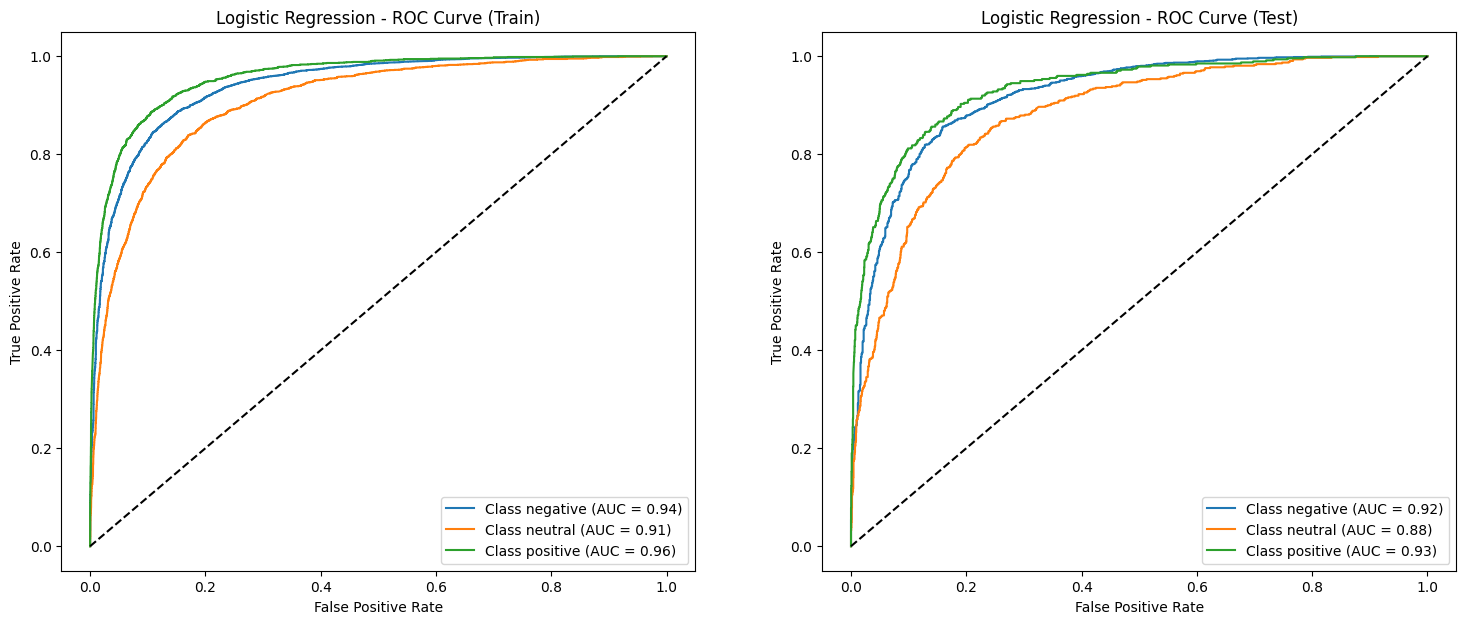

In [28]:
y_score_train = LogisticRegression_model.predict_proba(x_train)
y_score_test = LogisticRegression_model.predict_proba(x_test)

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_score_train[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("Logistic Regression - ROC Curve (Train)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.subplot(1,2,2)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("Logistic Regression - ROC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.show()


**Observation générale**  
- Courbes ROC train ≈ test → comportement stable.  
- Gap Accuracy ≈ 0.03 → peu d’overfitting. 

# Entraînement — SVC (One-vs-Rest)


=== SVC ===
Accuracy train: 0.9131
Accuracy test : 0.8207
Gap (overfitting): 0.0924


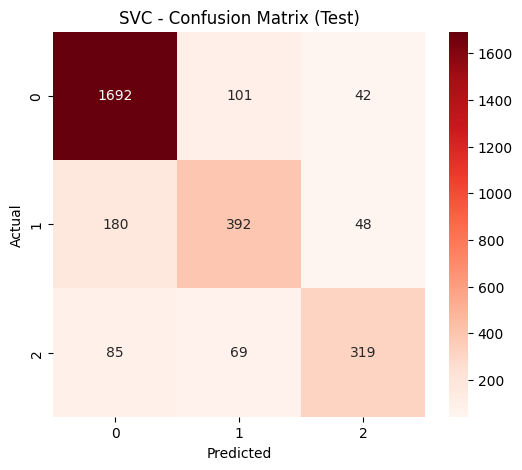

,precision,recall,f1-score,support
negative,0.864589,0.922071,0.892405,1835.000000
neutral,0.697509,0.632258,0.663283,620.000000
positive,0.779951,0.674419,0.723356,473.000000
accuracy,0.820697,0.820697,0.820697,0.820697
macro avg,0.780683,0.742916,0.759681,2928.000000
weighted avg,0.815537,0.820697,0.816580,2928.000000


In [29]:
svc = SVC(kernel="rbf", probability=True)

svc_model = OneVsRestClassifier(svc)

svc_model.fit(x_train, y_train)

y_pred_train = svc_model.predict(x_train)
y_pred_test  = svc_model.predict(x_test)

print("="*50)
print("=== SVC ===")
print("="*50)
acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test, y_pred_test)
print(f"Accuracy train: {acc_train:.4f}")
print(f"Accuracy test : {acc_test:.4f}")
print(f"Gap (overfitting): {acc_train - acc_test:.4f}")
print("="*50)

cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Reds")
plt.title("SVC - Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

report = classification_report(y_test, y_pred_test, output_dict=True)
display(pd.DataFrame(report).transpose())





**Résumé et explication (concise)**  
- Modèle non linéaire, flexible et expressif.  

  

**Pourquoi cela arrive**  
- SVC RBF est très flexible → peut bien séparer le train mais sur-ajuste le bruit.  
- Classes déséquilibrées → écarts de AUC par classe plus importants.  

**Conséquences pratiques**  
- Peut donner de meilleures performances brutes mais moins stable pour production.  
- Nécessite régularisation ou tuning pour réduire overfitting.  



# Courbes ROC — SVC


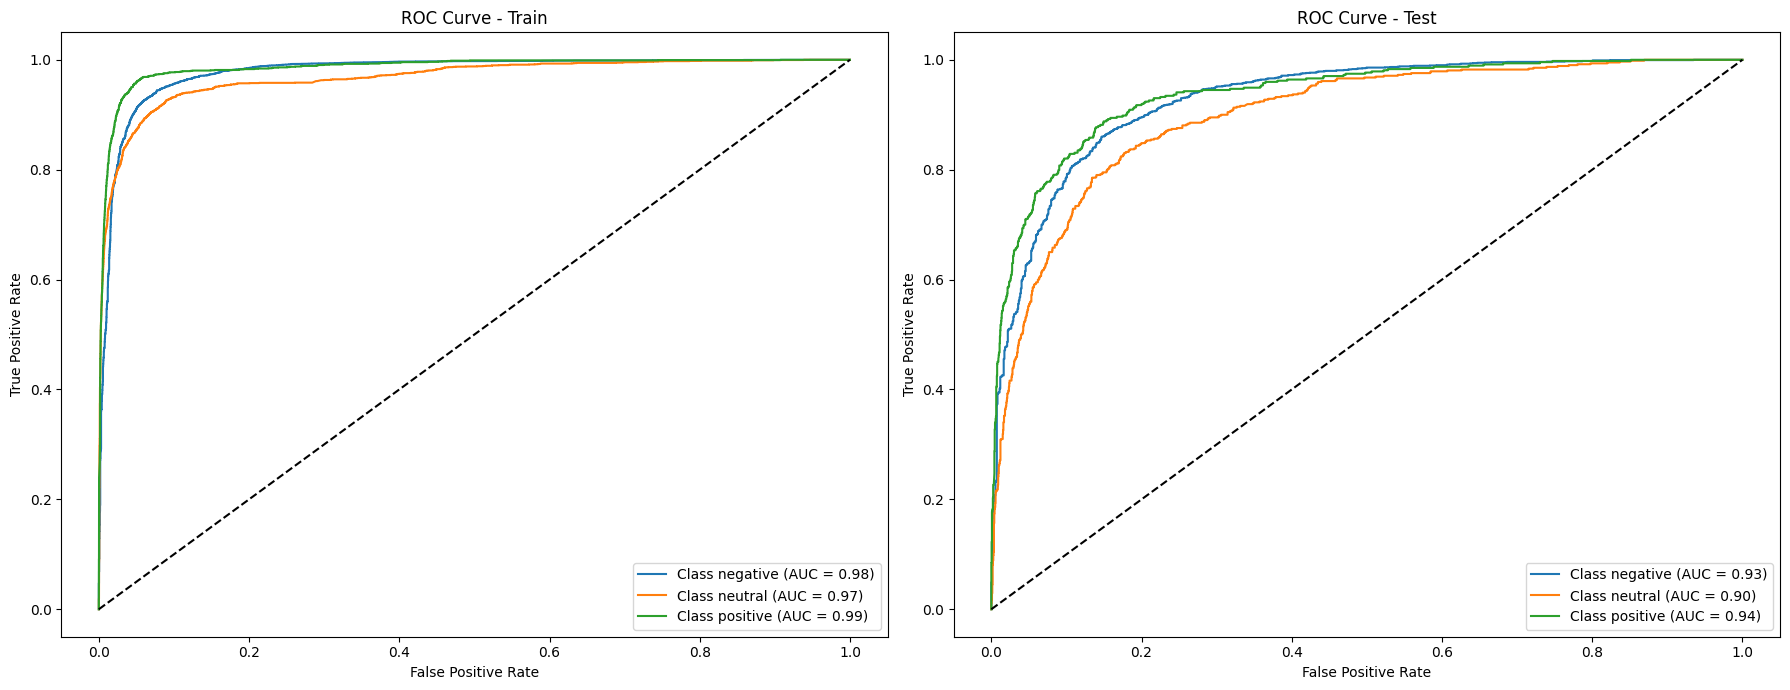

In [34]:
y_score_test  = svc_model.predict_proba(x_test)
y_score_train = svc_model.predict_proba(x_train)

plt.figure(figsize=(18,7))

plt.subplot(1,2,2)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Test")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1,2,1)
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_score_train[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve - Train")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.show()


**Observation générale**  
- Courbes ROC train nettement meilleures que test → overfitting probable.  
- Gap Accuracy ≈ 0.09 → surapprentissage.

##  Évaluation technique et justification du choix du modèle

Dans le cadre de la classification multi-classes de données textuelles basées sur des embeddings, deux modèles supervisés ont été évalués : **Logistic Regression** et **Support Vector Classifier (SVC)**.  
L’analyse repose à la fois sur les performances globales (accuracy), la capacité de généralisation (écart train/test) et la qualité de discrimination mesurée par les **courbes ROC/AUC**.

###  Résultats quantitatifs

| Modèle               | Accuracy Train | Accuracy Test | Gap (Overfitting) |
|----------------------|----------------|---------------|-------------------|
| Logistic Regression  | 0.8343         | 0.8019        | **0.0324**        |
| SVC                  | **0.9131**     | **0.8207**    |  **0.0924**      |

###  Analyse des performances

- **Logistic Regression** présente un écart train/test faible, indiquant une bonne capacité de généralisation et un comportement stable face aux données non vues.
- **SVC** atteint une accuracy plus élevée sur le jeu d’entraînement et légèrement supérieure sur le jeu de test, mais au prix d’un écart plus important, traduisant un risque de surapprentissage.
- La différence d’accuracy sur le jeu de test entre les deux modèles reste marginale, tandis que la différence de stabilité est significative.

###  Analyse ROC / AUC

- Les courbes ROC ont été calculées selon une approche **One-vs-Rest**, avec binarisation des labels et utilisation des probabilités de sortie.
- **Logistic Regression** montre des courbes ROC plus régulières et des valeurs d’AUC homogènes entre les classes, ce qui indique une capacité de discrimination stable.
- **SVC** présente des variations plus marquées des AUC selon les classes, suggérant une sensibilité accrue au bruit et au déséquilibre des données.
- La cohérence des AUC entre entraînement et test pour Logistic Regression confirme sa robustesse.

###  Choix du modèle

Au regard de l’ensemble des métriques (accuracy, généralisation et ROC/AUC), **Logistic Regression** est retenue comme modèle final.  
Ce choix privilégie la stabilité, la robustesse et la fiabilité des probabilités prédites, des critères essentiels pour une mise en production dans un contexte NLP réel.

> **Conclusion technique :** Le modèle sélectionné maximise la capacité de généralisation et la cohérence des performances, plutôt que la performance brute sur le jeu d’entraînement.
